# Usage of [`turboSETI`](https://github.com/UCBerkeleySETI/turbo_seti)
Updated 2020-07-09 by Shane Smith

---
## Intro
`turboSETI` is a Python tool used and developed by SETI researchers at the [Berkeley SETI Research Center](https://seti.berkeley.edu). The alogorithm searches for narrow band signals which have a doppler drift, a feature expected to be seen from an alien source with a non-zero acceleration relative to our recievers on Earth. <br/>

A basic introduction on installation and usage is given on `turboSETI`'s [README.md on GitHub](https://github.com/UCBerkeleySETI/turbo_seti/blob/master/README.md). This tutorial intends to give a more comprehensive look at the usage of the tools contained in `turboSETI`. <br/>

`turboSETI` can be cloned from the GitHub repo and installed by using:<br/>
```pip install git+https://github.com/UCBerkeleySETI/turbo_seti``` <br/>
The following packages are used in turboSETI:
- [astropy](https://www.astropy.org/)
- [cython](https://pypi.org/project/Cython/)
- [numpy](https://numpy.org/install/)
- [blimpy](https://github.com/UCBerkeleySETI/blimpy) <br/>

## Creating a Search Routine
Now that we have `turboSETI` installed we can start a Doppler drift search on some data. First we want to create a search object using `turbo_seti.find_doppler.find_doppler.FindDoppler()`

In [4]:
from turbo_seti.find_doppler.find_doppler import FindDoppler
FindDoppler?

Init signature:
FindDoppler(
    datafile,
    max_drift,
    min_drift=0,
    snr=25.0,
    out_dir='./',
    coarse_chans=None,
    obs_info=None,
    flagging=None,
    n_coarse_chan=None,
)
Init docstring:
Initializes FindDoppler object

Args:
    datafile (string):  Inputted filename (.h5 or .fil)
    max_drift (float):  Max drift rate in Hz/second
    min_drift (int):    Min drift rate in Hz/second
    snr (float):        Signal to Noise Ratio - A ratio bigger than 1 to 1 has more signal than  noise
    out_dir (string):   Directory where output files should be placed. By default this is the
                        current working directory.
    coarse_chans (list(int)):  the inputted comma separated list of coarse channels to analyze, if any.
    obs_info (dict):     Used to hold info found on file, including info about pulsars, RFI, and SEFD
    flagging (bool):     Flags the edges of the PFF for BL data (with 3Hz res per channel)
    n_coarse_chan (int): Number of coarse chann

From the docstring, we see that we will need to find a .h5 or .fil file to perform a search on. 

We'll conduct the search on an observation of HIP33499 which is in the [Breakthrough Listen Open Data Archive](http://seti.berkeley.edu/opendata). The files I am using in this tutorial are quite large (~3 GB). Use caution when downloading these large files from the Archive. If you do have access to the BL servers, it is reccomended you run `turboSETI` in your scratch space.

If running on the BL servers, you can obtain the file location on the server from the download link by using a handy script made by Steve Croft: <br/>
`$ mnt_home/scroft/parsefile <link from open data archive>`.

Typical SETI searches, such as [Price et. al]('/mnt_blpd8/datax/dl/Parkes_57770_77966_PROXCEN_fine.h5'), have used drift rates of up to $\pm 4$Hz. For this example we'll use $\pm 1$Hz so the `turboSETI` takes less time to run. Most searches also set the minimum signal to noise ratio to 10, but we'll use 25 for the sake of time.


In [9]:
# I am writing this notebook on the BSRC data center servers, so I am referencing the direct location on the server.
# Here is a link to the download: http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_12846_HIP33499_S_fine.h5
doppler = FindDoppler('/mnt_blpd8/datax2/dl/Parkes_57941_12846_HIP33499_S_fine.h5',
                      max_drift = 1,
                      min_drift = -1,# A max drift of 1 assumes a drift rate of +/- 1
                      snr = 25,       
                      out_dir = '/datax/scratch/ssmith/turboSETI_example/' # This is where the turboSETI output files will be stored
                     )

Now we run the search routine on the object we created:

In [20]:
doppler.search()

You will find that the search process can take many hours, especially when looking at multiple files. If you are doing your work on the BL servers or any other server system where you will be kicked out after an amount of time, I reccomend using either [tmux](https://github.com/tmux/tmux/wiki) or [screen](https://linuxize.com/post/how-to-use-linux-screen/). Terminal usage for `turboSETI` is as follows:

```
(bl) ssmith@blpc0:~$ turboSETI -h
Usage: python seti_event.py <FULL_PATH_TO_FIL_FILE> [options]

Options:
  -h, --help            show this help message and exit
  -M MAX_DRIFT, --max_drift=MAX_DRIFT
                        Set the drift rate to search. Unit: Hz/sec. Default:
                        10.0
  -s SNR, --snr=SNR     SNR threshold. Default: 25.0
  -o OUT_DIR, --out_dir=OUT_DIR
                        Location for output files. Default: local dir.
  -l LOGLEVEL, --loglevel=LOGLEVEL
                        Specify log level (info, debug)
  -c COARSE_CHANS, --coarse_chans=COARSE_CHANS
                        Coma separated list of coarse channels to analyze.(ie.
                        "5,8" to do from 5th to 8th coarse channels)

```

The parameters are the same as the initialization we performed, but this command is only one step. The search process will start on it's own after you input your desired parameters.

`turboSETI` creates the following output files:
- `.h5` --- If your input file is a guppi raw or filterbank file, it will create a copy of it in hdf5 format
- `.dat` --- This is the most interesting file, it contains all of `turboSETI`'s hits
- `.log` --- This is the logged output of the search algorithm.

## Plotting Hits
Now lets analyze the output that this search created. First we want to convert the `.dat` file into a [Pandas](https://pandas.pydata.org/) dataframe:

In [230]:
from turbo_seti.find_event.find_event import make_table

df = make_table('/datax/scratch/ssmith/turboSETI_example/Parkes_57941_12846_HIP33499_S_fine.dat')
# This is optional, but I like to set the table index to the hit number for simplicity
df = df.set_index('TopHitNum')
# Lets also sort by DriftRate so we can see Doppler drifted signals that would be characteristic of a transmitter with a nonzero acceleration.
df.sort_values('DriftRate')

,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,Source,MJD,RA,DEC,DELTAT,DELTAF,Hit_ID,status,in_n_ons,RFI_in_range
TopHitNum,,,,,,,,,,,,,,,,,,,
955,-0.248729,39.371286,3179.658243,754290,3179.657832,3179.658648,206,3143,Parkes_57941_12846_HIP33499_S_fine.h5,HIP33499_S,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,,,
982,-0.248729,200.948871,3249.970095,754058,3249.969684,3249.970500,230,4565,Parkes_57941_12846_HIP33499_S_fine.h5,HIP33499_S,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,,,
847,-0.248729,43.398942,2874.973551,755295,2874.973140,2874.973956,102,3163,Parkes_57941_12846_HIP33499_S_fine.h5,HIP33499_S,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,,,
891,-0.229596,102.566087,2999.972395,405356,2999.971985,2999.972800,145,3390,Parkes_57941_12846_HIP33499_S_fine.h5,HIP33499_S,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,,,
802,-0.220029,158.696246,2749.974698,56655,2749.974288,2749.975104,60,3607,Parkes_57941_12846_HIP33499_S_fine.h5,HIP33499_S,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,0.114798,25.117792,3214.516139,647505,3214.515729,3214.516544,218,3120,Parkes_57941_12846_HIP33499_S_fine.h5,HIP33499_S,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,,,
793,0.344394,28.790069,2728.932816,914080,2728.932406,2728.933221,52,3149,Parkes_57941_12846_HIP33499_S_fine.h5,HIP33499_S,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,,,
796,0.353960,2491.340503,2734.032785,642278,2734.032375,2734.033190,54,12307,Parkes_57941_12846_HIP33499_S_fine.h5,HIP33499_S,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,,,


TopHitNum 982 looks like a very bright signal that'll be visible, let's go ahead a plot it using the built-in plotting function:

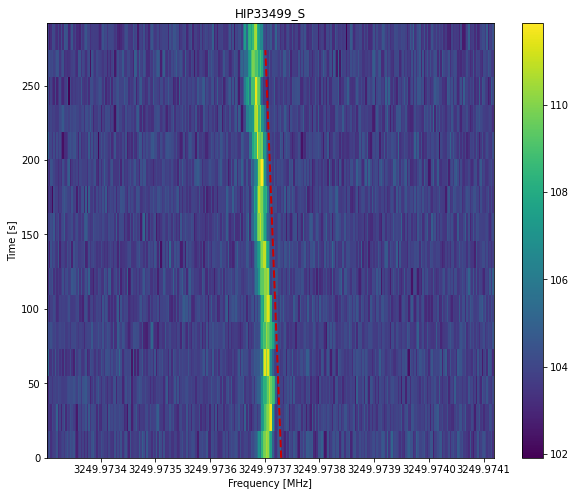

In [239]:
from turbo_seti import plot_event
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,8)) # Because plot_hit uses matplotlib, I can set parameters such as the figure size.
                                       # Creating subplots is optional for plotting an event.
plot_event.plot_hit(fil_filename = '/mnt_blpd8/datax2/dl/Parkes_57941_12846_HIP33499_S_fine.h5',
                    dat_filename = '/datax/scratch/ssmith/turboSETI_example/Parkes_57941_12846_HIP33499_S_fine.dat',
                    hit_id = 982,
                    offset = 20) # An offset in Hz that shifts turboSETI's fitted slope of the signal (dashed line)

## Finding Events
Great, `turboSETI` found a signal with a drifting frequency! However, we cannot say with any certainty whether this signal is RFI or extraterrestrial. Lets run `turboSETI` on more files from the same observation so we can reject RFI via the [ON/OFF method](https://github.com/UCBerkeleySETI/breakthrough/blob/master/GBT/README.md). Here is a complete list of the files I'll be looking at:

http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_12846_HIP33499_S_fine.h5 <br/>
http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_13194_HIP33499_R_fine.h5 <br/>
http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_13542_HIP33499_S_fine.h5 <br/>
http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_13884_HIP33499_R_fine.h5 <br/>
http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_14233_HIP33499_S_fine.h5 <br/>
http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_14584_HIP33499_R_fine.h5 <br/>

The "_S_" in the file names stands for "Source" (ON) and the R means "Reference" (OFF). It'll take a chunk of time to run the algorithm on all of the files, so here is a little script I wrote so that I can keep it running in the background with tmux:

In [1]:
# %load example_script.py
import os

filelist = [# 'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_12846_HIP33499_S_fine.h5', excluding the first file because we already ran turboSETI on it
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_13194_HIP33499_R_fine.h5',
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_13542_HIP33499_S_fine.h5',
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_13884_HIP33499_R_fine.h5',
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_14233_HIP33499_S_fine.h5',
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_14584_HIP33499_R_fine.h5']

out_directory = '/datax/scratch/ssmith/turboSETI_example/'

for file in filelist:
    
    # Convert the URL link to a file location
    file_loc = os.popen('/mnt_home/scroft/parsefile ' + file).read()
    file_loc = file_loc.split('\n')[0]
    
    console = 'turboSETI '+file_loc+' -M 1 -s 25 -o '+out_directory
    os.system(console)

Now that we have ran `turboSETI` on six observations, let's use [Sofia Sheikh](https://github.com/Sofysicist)'s `find_event_pipeline` to find events that only exist in the on observations. `find_event_pipeline`'s only required parameter is a .lst text file where each line entry is the file location of a `.dat` file. Two other important parameters are the filter_threshold and cadence_length. Here is a docstring explaining what filter threshold is:
```
filter_threshold        Specification for how strict the hit filtering will be.
                        There are 3 different levels of filtering, specified by
                        the integers 1, 2, and 3. Filter_threshold = 1 
                        returns hits above an SNR cut, taking into account the
                        check_zero_drift parameter, but without an ON-OFF check.
                        Filter_threshold = 2 returns hits that passed level 1
                        AND that are in at least one ON but no OFFs. 
                        Filter_threshold = 3 returns events that passed level 2
                        AND that are present in *ALL* ONs. Default is 3.
```
cadence_length is the number of files we wish to include in our cadence. By default the value is 6.

In [1]:
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline

# A list of all the .dat files that turboSETI produced
dat_list = ['/datax/scratch/ssmith/turboSETI_example/Parkes_57941_12846_HIP33499_S_fine.dat',
             '/datax/scratch/ssmith/turboSETI_example/Parkes_57941_13194_HIP33499_R_fine.dat',
             '/datax/scratch/ssmith/turboSETI_example/Parkes_57941_13542_HIP33499_S_fine.dat',
             '/datax/scratch/ssmith/turboSETI_example/Parkes_57941_13884_HIP33499_R_fine.dat',
             '/datax/scratch/ssmith/turboSETI_example/Parkes_57941_14233_HIP33499_S_fine.dat',
             '/datax/scratch/ssmith/turboSETI_example/Parkes_57941_14584_HIP33499_R_fine.dat']

# This writes the dat files into a .lst, as required by the find_event_pipeline
with open('turboSETI_tutorial/dat_files.lst', 'w') as f:
    for item in dat_list:
        f.write("%s\n" % item)

find_event_pipeline('turboSETI_tutorial/dat_files.lst',
                                        filter_threshold = 3,
                                        number_in_cadence = 6)


************   BEGINNING FIND_EVENT PIPELINE   **************

Assuming the first observation is an ON
There are 6 total files in the filelist turboSETI_tutorial/dat_files.lst
therefore, looking for events in 1 on-off set(s)
with a minimum SNR of 10
Present in all A sources with RFI rejection from the off-sources
not including signals with zero drift
saving the output files

***       S       ***

------   o   -------
Loading data...
Loaded 1060 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_12846_HIP33499_S_fine.dat
Loaded 1197 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_13194_HIP33499_R_fine.dat
Loaded 1991 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_13542_HIP33499_S_fine.dat
Loaded 1468 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_13884_HIP33499_R_fine.dat
Loaded 1343 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_14233_HIP33499_S_fine.dat
Loaded 920 hits from /datax/scratch/ssmith/turboSETI_exa

[]

No events have been found across the entire cadence, so our ON/OFF method succcessfuly rejected all hits as RFI! Let's change the filter level to 2 and see what we get

In [2]:
event_df = find_event_pipeline('turboSETI_tutorial/dat_files.lst',
                                                   filter_threshold = 2,
                                                   number_in_cadence = 6) #Due to our limited search parameters of snr = 25 and drift_rate = +/-1,
                                                                          # we had to set the cadence length to 2 to get any results.


************   BEGINNING FIND_EVENT PIPELINE   **************

Assuming the first observation is an ON
There are 6 total files in the filelist turboSETI_tutorial/dat_files.lst
therefore, looking for events in 1 on-off set(s)
with a minimum SNR of 10
Present in at least one A source with RFI rejection from the off-sources
not including signals with zero drift
saving the output files

***       S       ***

------   o   -------
Loading data...
Loaded 1060 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_12846_HIP33499_S_fine.dat
Loaded 1197 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_13194_HIP33499_R_fine.dat
Loaded 1991 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_13542_HIP33499_S_fine.dat
Loaded 1468 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_13884_HIP33499_R_fine.dat
Loaded 1343 hits from /datax/scratch/ssmith/turboSETI_example/Parkes_57941_14233_HIP33499_S_fine.dat
Loaded 920 hits from /datax/scratch/ssmith/turbo

## Plotting events
Now that we have some events, let's plot them

Currently (July 9th, 2020), the plotting tools in the master branch of `turboSETI` are not functional. To use the functioning version of these tools, you can install [Sofia Sheikh's version](https://github.com/Sofysicist/turbo_seti). However, keep in mind that this build is still under development and may have bugs.

The best option that I've found for using the plotting tool while avoiding bugs is to clone or download the [plot_event.py](https://github.com/Sofysicist/turbo_seti/blob/master/turbo_seti/find_event/plot_event.py) and [plot_event_pipeline.py](https://github.com/Sofysicist/turbo_seti/blob/master/turbo_seti/find_event/plot_event_pipeline.py) from Sofia's repository and then import them as their own modules. I've downloaded both of these files into a directory named `turbo_seti_sofia` and will be referencing them as such.

The `plot_event_pipeline` will output the plots as .png's and show them inline. There are two required parameters, a `.csv` outputted by the `find_event_pipeline` and a `.lst` of `.h5` files that will be plotted. I am also setting the user_validation to True because I do not want to accidentally generate 100's of .pngs.

In [3]:
import os
from turbo_seti_sofia.plot_event_pipeline import plot_event_pipeline

# We need to create a .lst of the .h5 files, so lets go ahead and do that:
filelist = ['http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_12846_HIP33499_S_fine.h5',
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_13194_HIP33499_R_fine.h5',
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_13542_HIP33499_S_fine.h5',
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_13884_HIP33499_R_fine.h5',
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_14233_HIP33499_S_fine.h5',
            'http://blpd8.ssl.berkeley.edu/dl2/Parkes_57941_14584_HIP33499_R_fine.h5'
           ]

# Create a python list of the file locations
new_filelist = [0] * len(filelist)
for i, file in enumerate(filelist):
    # Convert the URL link to a file location
    file_loc = os.popen('/mnt_home/scroft/parsefile ' + file).read()
    new_filelist[i] = file_loc.split('\n')[0]

# Write file locations to a .lst
with open('turboSETI_tutorial/fil_files.lst', 'w') as f:
    for item in new_filelist:
        f.write("%s\n" % item)

# and finally we plot
plot_event_pipeline('turboSETI_tutorial/S_fine_f2_snr10.csv',
                    'turboSETI_tutorial/fil_files.lst',
                    user_validation=True)

Plotting some events for:  HIP33499_S
There are 118 total events in the csv file turboSETI_tutorial/S_fine_f2_snr10.csv
therefore, you are about to make 118 .png files.


Do you wish to proceed with these settings? (y/n):  n


I'm not interested in generating 118 plots, so I'm going to select 2 hits to plot:

In [4]:
event_df.iloc[0:2].to_csv('turboSETI_tutorial/condensed_fine_f2_snr10.csv') # The filename must have the same format as the .csv 
                                                                            # outputed by find_event_pipeline
event_df.iloc[0:2]

,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,...,MJD,RA,DEC,DELTAT,DELTAF,Hit_ID,status,in_n_ons,RFI_in_range,delta_t
384,385,-0.019133,28.443213,2678.159002,567216,2678.158591,2678.159407,35,3690,Parkes_57941_12846_HIP33499_S_fine.h5,...,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,on_table_1,,0,0.0
792,793,0.344394,28.790069,2728.932816,914080,2728.932406,2728.933221,52,3149,Parkes_57941_12846_HIP33499_S_fine.h5,...,57941.148680555554,6h57m46.6s,-43d42m32s,18.253611,2.793968,,on_table_1,,0,0.0


Plotting some events for:  HIP33499_S
There are 2 total events in the csv file turboSETI_tutorial/condensed_fine_f2_snr10.csv
therefore, you are about to make 2 .png files.


Do you wish to proceed with these settings? (y/n):  y



*************************************************
***     The Parameters for This Plot Are:    ****
Target =  HIP33499_S
Bandwidth =  0.0005  MHz
Time Elapsed (inc. Slew) =  2012.0  s
Middle Frequency =  2678.159  MHz
Expected Drift =  -0.0191  Hz/s
*************************************************
*************************************************


*************************************************
***     The Parameters for This Plot Are:    ****
Target =  HIP33499_S
Bandwidth =  0.00166  MHz
Time Elapsed (inc. Slew) =  2012.0  s
Middle Frequency =  2728.9328  MHz
Expected Drift =  0.3444  Hz/s
*************************************************
*************************************************



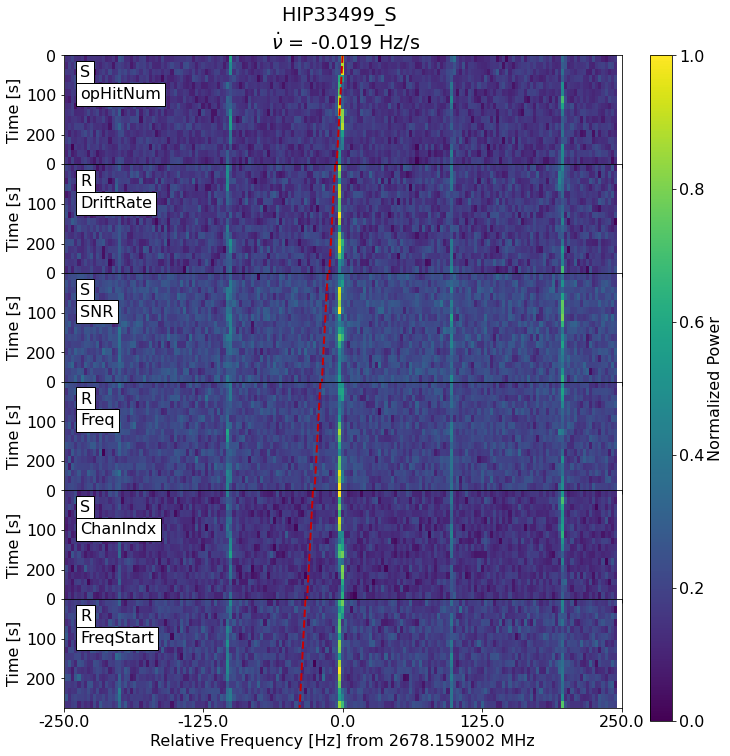

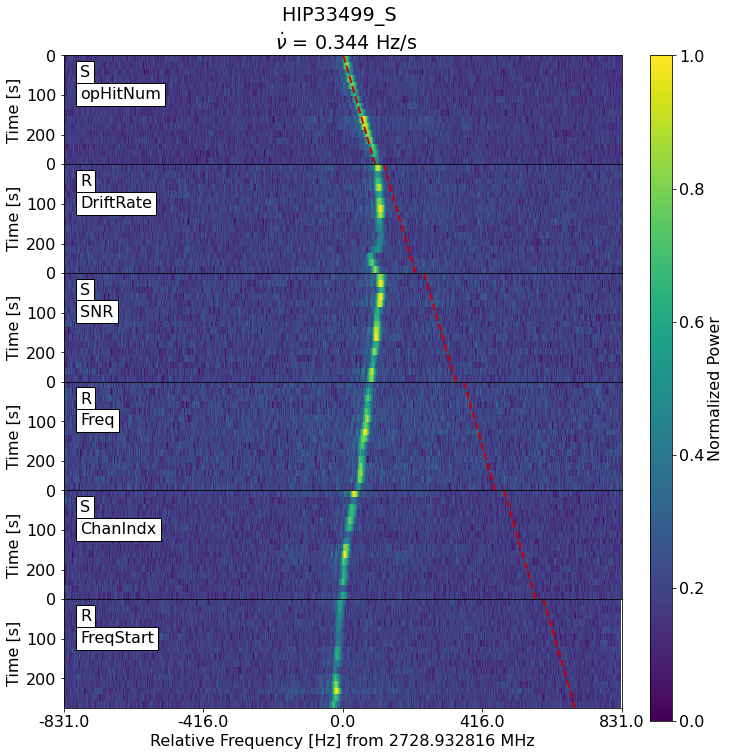

In [7]:
plot_event_pipeline('turboSETI_tutorial/condensed_fine_f2_snr10.csv',
                    'turboSETI_tutorial/fil_files.lst',
                    user_validation=True)

We can immediately classify both of these plots as RFI because it is clear to us that the hit is present in all 6 plots. `turboSETI` only sees the event in one of the plots because it is searching for specific Doppler drift rates. It detects a drift rate from a hit in the first plot, but doesn't detect that drift rate in the following plots because the drift rate is changing over time. The diverging dashed line is the drift rate the `turboSETI` does not see in the other plots.